# To Grant or Not to Grant: Deciding on Compensation Benefits 

### Machine Learning Group Project 2024/2025 - Group 52


__Members:__
- Diogo Rodrigues _(20240512@novaims.unl.pt)_
- Alexandre Gonçalves _(20240738@novaims.unl.pt)_
- Pedro Costa _(20222121@novaims.unl.pt)_
- Santiago Taylor _(20240542@novaims.unl.pt)_
- Lena Hermann _(20241446@novaims.unl.pt)_

## Introduction
- __Motivation__: x
- __Dataset__: The dataset represents claims from the start of 2020 till the end of 2022 (training data) and from January 2023 onward (test data). A detailed description of the columns of the datasets can be found below.
- __Task and Goal__: The purpose of this notebook is to create and evaluate several classification models for accurately predicting the WCB’s final decision on what type of injury should be given to a claim.

| **ATTRIBUTE**                        | **DESCRIPTION**                                                                                                         |
|--------------------------------------|-------------------------------------------------------------------------------------------------------------------------|
| Accident Date                        | Injury date of the claim.                                                                                               |
| Age at Injury                        | Age of injured worker when the injury occurred.                                                                         |
| Alternative Dispute Resolution       | Adjudication processes external to the Board.                                                                           |
| Assembly Date                        | The date the claim was first assembled.                                                                                 |
| Attorney/Representative              | Is the claim being represented by an Attorney?                                                                          |
| Average Weekly Wage                  | The wage used to calculate workers’ compensation, disability, or Paid Leave wage replacement benefits.                  |
| Birth Year                           | The reported year of birth of the injured worker.                                                                       |
| C-2 Date                             | Date of receipt of the Employer's Report of Work-Related Injury/Illness or equivalent (formerly Form C-2).              |
| C-3 Date                             | Date Form C-3 (Employee Claim Form) was received.                                                                       |
| Carrier Name                         | Name of primary insurance provider responsible for providing workers’ compensation coverage to the injured worker's employer. |
| Carrier Type                         | Type of primary insurance provider responsible for providing workers’ compensation coverage.                            |
| Claim Identifier                     | Unique identifier for each claim, assigned by WCB.                                                                      |
| County of Injury                     | Name of the New York County where the injury occurred.                                                                  |
| COVID-19 Indicator                   | Indication that the claim may be associated with COVID-19.                                                              |
| District Name                        | Name of the WCB district office that oversees claims for that region or area of the state.                              |
| First Hearing Date                   | Date the first hearing was held on a claim at a WCB hearing location. A blank date means the claim has not yet had a hearing held. |
| Gender                               | The reported gender of the injured worker.                                                                              |
| IME-4 Count                          | Number of IME-4 forms received per claim. The IME-4 form is the “Independent Examiner’s Report of Independent Medical Examination” form. |
| Industry Code                        | NAICS code and descriptions are available at https://www.naics.com/search-naics-codes-by-industry/.                     |
| Industry Code Description            | 2-digit NAICS industry code description used to classify businesses according to their economic activity.               |
| Medical Fee Region                   | Approximate region where the injured worker would receive medical service.                                               |
| OIICS Nature of Injury Description   | The OIICS nature of injury codes & descriptions are available at https://www.bls.gov/iif/oiics_manual_2007.pdf.         |
| WCIO Cause of Injury Code            | The WCIO cause of injury codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Cause_Table.pdf.  |
| WCIO Cause of Injury Description     | See description of field above.                                                                                         |
| WCIO Nature of Injury Code           | The WCIO nature of injury are available at https://www.wcio.org/Active%20PNC/WCIO_Nature_Table.pdf.                     |
| WCIO Nature of Injury Description    | See description of field above.                                                                                         |
| WCIO Part Of Body Code               | The WCIO part of body codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Part_Table.pdf.      |
| WCIO Part Of Body Description        | See description of field above.                                                                                         |
| Zip Code                             | The reported ZIP code of the injured worker’s home address.                                                             |
| Agreement Reached                    | Binary variable: Yes if there is an agreement without the involvement of the WCB -> unknown at the start of a claim.    |
| WCB Decision                         | Multiclass variable: Decision of the WCB relative to the claim: “Accident” means that claim refers to workplace accident, “Occupational Disease” means illness from the workplace. -> requires WCB deliberation so it is unknown at start of claim. |
| Claim Injury Type                    | Main target variable: Deliberation of the WCB relative to benefits awarded to the claim. Numbering indicates severity.   |


## Table of Content
<a id='top'></a>
[1. Set-Up and Data Loading](#dataload) <br>
[2. Data Understanding and Exploration](#dataunderstand) <br>
[3. Data Cleaning and Pre-processing](#dataclean) <br>
[4. Feature Selection](#features) <br>
[5. Modeling and Evaluation](#modeling) <br>

## 1. Set-Up and Data Loading <a id='dataload'></a>
[to the top](#top)

### 1.1 Import the needed libraries

In [2]:
import numpy as np #to efficiently compute functions
import pandas as pd #to work with data frames
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import zipfile #to open zipfile

# data partition
from sklearn.model_selection import train_test_split

#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE


# embedded methods
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

### 1.2 Read the data and first overview

In [3]:
train_zip_path = 'train_data.csv.zip'
test_zip_path = 'test_data.csv.zip'

# open csv file from zip
def read_zipped_csv(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        csv_filename = z.namelist()[0]
        
        with z.open(csv_filename) as f:
            return pd.read_csv(f)

train_df = read_zipped_csv(train_zip_path)
test_df = read_zipped_csv(test_zip_path)

print("Train Data:")
print(train_df.head())
print("\nTest Data:")
print(test_df.head())

Train Data:
  Accident Date  Age at Injury Alternative Dispute Resolution Assembly Date  \
0    2019-12-30           31.0                              N    2020-01-01   
1    2019-08-30           46.0                              N    2020-01-01   
2    2019-12-06           40.0                              N    2020-01-01   
3           NaN            NaN                            NaN    2020-01-01   
4    2019-12-30           61.0                              N    2020-01-01   

  Attorney/Representative  Average Weekly Wage  Birth Year    C-2 Date  \
0                       N                 0.00      1988.0  2019-12-31   
1                       Y              1745.93      1973.0  2020-01-01   
2                       N              1434.80      1979.0  2020-01-01   
3                     NaN                  NaN         NaN         NaN   
4                       N                  NaN      1958.0  2019-12-31   

     C-3 Date                  Carrier Name  ... WCIO Cause of Injur

In [4]:
train_df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


## 2. Data Understanding and Exploration <a id='dataunderstand'></a>
[to the top](#top)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [6]:
# Have a first look at the numerical variables and their distirbutions
train_df.describe()

,Age at Injury,Average Weekly Wage,Birth Year,Claim Identifier,IME-4 Count,Industry Code,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
count,574026.000000,5.453750e+05,544948.000000,5.934710e+05,132803.000000,564068.000000,0.0,558386.000000,558369.000000,556944.000000,574026.000000,574026.000000
mean,42.114270,4.910883e+02,1886.767604,2.366760e+07,3.207337,58.645305,NaN,54.381143,41.013839,39.738146,0.046665,3.006559
std,14.256432,6.092918e+03,414.644423,1.079271e+08,2.832303,19.644175,NaN,25.874281,22.207521,22.365940,0.210921,2.000801
min,0.000000,0.000000e+00,0.000000,5.393066e+06,1.000000,11.000000,NaN,1.000000,1.000000,-9.000000,0.000000,0.000000
25%,31.000000,0.000000e+00,1965.000000,5.593414e+06,1.000000,45.000000,NaN,31.000000,16.000000,33.000000,0.000000,1.000000
50%,42.000000,0.000000e+00,1977.000000,5.791212e+06,2.000000,61.000000,NaN,56.000000,49.000000,38.000000,0.000000,3.000000
75%,54.000000,8.410000e+02,1989.000000,5.991000e+06,4.000000,71.000000,NaN,75.000000,52.000000,53.000000,0.000000,5.000000
max,117.000000,2.828079e+06,2018.000000,9.998917e+08,73.000000,92.000000,NaN,99.000000,91.000000,99.000000,1.000000,6.000000


In [7]:
# Have a first look at the categorical variables and their distirbutions
train_df.describe(include='O')

,Accident Date,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,...,District Name,First Hearing Date,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,WCIO Nature of Injury Description,WCIO Part Of Body Description,Zip Code,WCB Decision
count,570337,574026,593471,574026,559466,187245,574026,574026,574026,574026,...,574026,150798,574026,564068,574026,558386,558369,556944,545389,574026
unique,5539,3,1096,2,2475,1648,2046,8,8,63,...,8,1094,4,20,5,74,56,54,10060,1
top,2020-03-01,N,2020-03-06,N,2021-05-11,2021-04-21,STATE INSURANCE FUND,1A. PRIVATE,2. NON-COMP,SUFFOLK,...,NYC,2022-04-15,M,HEALTH CARE AND SOCIAL ASSISTANCE,IV,LIFTING,STRAIN OR TEAR,LOWER BACK AREA,11236,Not Work Related
freq,1245,571412,1422,392291,1847,350,111144,285368,291078,60430,...,270779,440,335218,114339,265981,46610,153373,51862,3302,574026


__Target Variable__

We just have a look at the distribution of the target variable 'Claim Injury Type'. To check how our dataset is balanced.

In [8]:
train_df['Claim Injury Type'].value_counts()

2. NON-COMP        291078
4. TEMPORARY       148507
3. MED ONLY         68906
5. PPD SCH LOSS     48280
1. CANCELLED        12477
6. PPD NSL           4211
8. DEATH              470
7. PTD                 97
Name: Claim Injury Type, dtype: int64

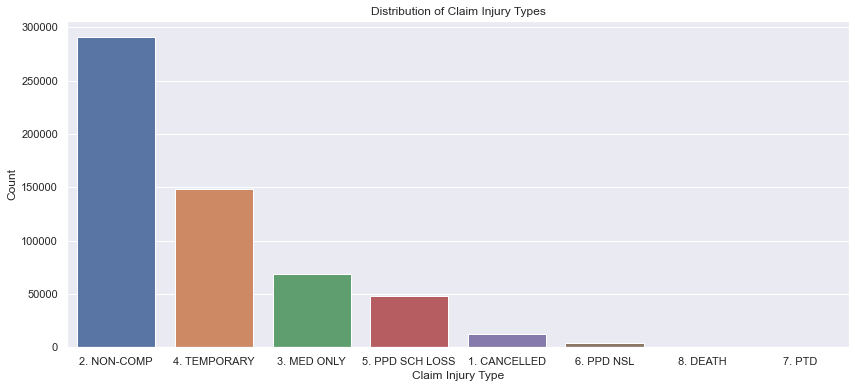

In [9]:
# Plot distribution of target values
target_values = train_df['Claim Injury Type'].value_counts()

df_target_counts = target_values.reset_index()
df_target_counts.columns = ['Claim Injury Type', 'Count']

plt.figure(figsize=(14, 6))
sns.barplot(x='Claim Injury Type', y='Count', data=df_target_counts)
#plt.xticks(rotation=45)
plt.title('Distribution of Claim Injury Types')
plt.show()

In [10]:
# include more variables !

_"Explore data visually and extract relevant insights. Explain your rationale and
findings. Do not forget to analyse multivariate relationships."_

## 3. Data Cleaning and Pre-processing <a id='dataclean'></a>
[to the top](#top)

- _"Are there any missing values? Take action to handle them._
- _Check the dataset for outliers and pre-process them. Justify your decisions._
- _Deal with categorical variables._
- _Review current features and create extra features if needed. Explain your steps._
- _Perform data scaling. Explain the reasoning behind your choices."_

### 3.1 Missing Values

In [11]:
# Calculation of the number and percentage of missing values per column
missing_values = train_df.isna().sum()
missing_percentage = round((train_df.isna().sum() / len(train_df)) * 100,2)

missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

print(missing_data)

                                    Missing Values  Percentage
Accident Date                                23134        3.90
Age at Injury                                19445        3.28
Alternative Dispute Resolution               19445        3.28
Assembly Date                                    0        0.00
Attorney/Representative                      19445        3.28
Average Weekly Wage                          48096        8.10
Birth Year                                   48523        8.18
C-2 Date                                     34005        5.73
C-3 Date                                    406226       68.45
Carrier Name                                 19445        3.28
Carrier Type                                 19445        3.28
Claim Identifier                                 0        0.00
Claim Injury Type                            19445        3.28
County of Injury                             19445        3.28
COVID-19 Indicator                           19445     

The first look at the missing values reveals four insights:
1. There exist __only two__ variables __without missing values__ (Assembly Date and Claim Identifier)
2. There exists __one__ variable with __only missing values__ (OIICS Nature of Injury Description). This variable will be dropped directly.
3. There exist __three__ variables with missing values ranging from __68% - 78%__, which might be dropped.
4. Several variabes show the __same amount of missing values__ (3.28% and 5.91%)
5. Our target variable __"Claim Injury Type"__ has __19445 missing values__. The respective rows can be dropped because imputation of the target variable introduces artificial outcomes, creating bias and compromising the integrity of our model.

In [12]:
# Drop the variable with only missing values
train_df_temp = train_df.drop(columns='OIICS Nature of Injury Description')

In [13]:
# Drop rows where the target variable is missing
train_df_temp = train_df_temp.dropna(subset=['Claim Injury Type'])

# Check the shape of the cleaned DataFrame
print(f"Remaining rows after dropping missing target values: {len(train_df_temp)}")
print(f"Percentage of the whole training data set: {round(len(train_df_temp)/len(train_df),2)*100}%")


Remaining rows after dropping missing target values: 574026
Percentage of the whole training data set: 97.0%


In [14]:
# Calculation of the number and percentage of missing values per column
missing_values2 = train_df_temp.isna().sum()
missing_percentage2 = round((train_df_temp.isna().sum() / len(train_df_temp)) * 100,2)

missing_data2 = pd.DataFrame({'Missing Values after dropping missing target value rows': missing_values2, 'Percentage': missing_percentage2})

print(missing_data2)

                                   Missing Values after dropping missing target value rows  \
Accident Date                                                                   3689         
Age at Injury                                                                      0         
Alternative Dispute Resolution                                                     0         
Assembly Date                                                                      0         
Attorney/Representative                                                            0         
Average Weekly Wage                                                            28651         
Birth Year                                                                     29078         
C-2 Date                                                                       14560         
C-3 Date                                                                      386781         
Carrier Name                                                

Nice! We can see that when dropping the rows with the missing target values, a lot of our features had the same missing values in these rows!

Let's have a look at the three variable with the high percentage of missing values:
- __IME-4 Count (77.62%)__: This variable describes the number of IME-4 forms received per claim. The missing values could be replaced with zeros, however, since the amout of missing values is so high, it's variance is relatively small.
- __First Hearing Date (74.59%)__: The description of the variable states that a blank date means the claim has not yet had a hearing held. The relationship between the date variables should be checked to determine if its relevant. Further, if the variable has an impact on the target variable, one idea would be to transform it into a binary variable which states if the first hearing date took place already (=1) or not (=0).
- __C-3 Date (68.45%)__: This variable means that the Date Form C-3 (Employee Claim Form) was received. It could also be transformed into a binary variable if it is important.

In [15]:
train_df_temp['IME-4 Count'].value_counts()

1.0     40112
2.0     34504
3.0     16136
4.0     13781
5.0      7680
6.0      6427
7.0      3838
8.0      3156
9.0      1915
10.0     1460
11.0     1002
12.0      807
13.0      516
14.0      396
15.0      273
16.0      214
18.0      140
17.0      125
19.0       79
20.0       56
21.0       53
22.0       34
23.0       19
24.0       16
27.0       14
26.0        8
25.0        7
29.0        5
28.0        4
30.0        4
32.0        4
34.0        4
36.0        3
33.0        2
31.0        2
39.0        2
37.0        1
48.0        1
35.0        1
47.0        1
73.0        1
Name: IME-4 Count, dtype: int64

In [16]:
# Since 'Claim Injury Type' is categorical, let's convert it to numeric to check for the correlation
train_df_temp['Claim Injury Type Numeric'] = train_df_temp['Claim Injury Type'].astype('category').cat.codes

# Calculate the correlation
correlation_value = train_df_temp[['Claim Injury Type Numeric', 'IME-4 Count']].corr().iloc[0, 1]
print(f"Correlation between IME-4 Count and Claim Injury Type: {correlation_value}")

Correlation between IME-4 Count and Claim Injury Type: 0.03152676879822572


Based on the low correlation to the target, we will drop the variable.

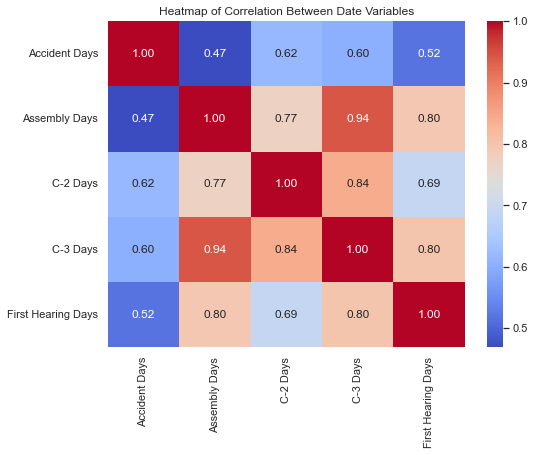

In [17]:
# Convert columns to datetime format and handle errors
train_df_date = train_df_temp.copy()
train_df_date['Accident Date'] = pd.to_datetime(train_df_date['Accident Date'], errors='coerce')
train_df_date['Assembly Date'] = pd.to_datetime(train_df_date['Assembly Date'], errors='coerce')
train_df_date['C-2 Date'] = pd.to_datetime(train_df_date['C-2 Date'], errors='coerce')
train_df_date['C-3 Date'] = pd.to_datetime(train_df_date['C-3 Date'], errors='coerce')
train_df_date['First Hearing Date'] = pd.to_datetime(train_df_date['First Hearing Date'], errors='coerce')

# Check for any correlation between date columns by converting them to numeric values (days since start)
train_df_date['Accident Days'] = (train_df_date['Accident Date'] - train_df_date['Accident Date'].min()).dt.days
train_df_date['Assembly Days'] = (train_df_date['Assembly Date'] - train_df_date['Accident Date'].min()).dt.days
train_df_date['C-2 Days'] = (train_df_date['C-2 Date'] - train_df_date['Accident Date'].min()).dt.days
train_df_date['C-3 Days'] = (train_df_date['C-3 Date'] - train_df_date['Accident Date'].min()).dt.days
train_df_date['First Hearing Days'] = (train_df_date['First Hearing Date'] - train_df_date['Accident Date'].min()).dt.days

# Correlation matrix for date columns
correlation_matrix_date = train_df_date[['Accident Days', 'Assembly Days', 'C-2 Days', 'C-3 Days', 'First Hearing Days']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_date, annot=True, cmap="coolwarm", fmt='.2f')
plt.title('Heatmap of Correlation Between Date Variables')
plt.show()

Looking at the date variables, transformed into days related to the accident day, we can see that _First Hearing Date_ and _C-3 Date_ have a very high correlation with _Assembly Days_. Therefore, we suggest to exclude them.

In [18]:
train_df_temp2 = train_df_temp.drop(columns=['First Hearing Date', 'C-3 Date', 'IME-4 Count'])

Since the other variables had missing values for less than 6%, let's check how many rows have no misisng values for all features.

In [19]:
# rows without missing values
rows_without_missing_values = train_df_temp2.dropna()
num_rows_without_missing_values = len(rows_without_missing_values)

print(f"Number of rows without missing values: {num_rows_without_missing_values}")
print(f"% of rows without missing values: {round((num_rows_without_missing_values / len(train_df_temp2)) * 100, 2)}%")

Number of rows without missing values: 473997
% of rows without missing values: 82.57%


So let's look at the other variables and how we can interpolate the missing values / which makes the most sense.

- __Average Weekly Wage__: use __median__ for missing values, since mean might be influenced by the extrem outliers we already saw.
- __Birth Year__: can be calculated by looking at "Age at Injury" and "Accident Date" (however it will probably not be needed since it is the same information than the both contain)
- __Accident Date__: the year could be calculated by "Birth Year" and "Age at Injury"
- __C-2 Date__: ?
- __Industry Code / Industry Code Description__: take the largest class (20%)
- __WCIO Cause of Injury Code / Description__: take the largest class or assign randomly ?
- __WCIO Nature of Injury Code / Description__: take the largest class (27%)
- __WCIO Part Of Body Code / Description__: take the largest class or assign randomly ?
- __Zip Code__: (delete because there are sooo many different ones)


-> randomly weighted distribution


__Average Weekly Wage__

In [42]:
max_avg_ww = train_df['Average Weekly Wage'].value_counts().max()

print(f'Most frequent value of Average Weekly Wage: {max_avg_ww}')
print(f'% of most frequent value of Average Weekly Wage: {round(max_avg_ww / len(train_df),2)*100}%')

Most frequent value of Average Weekly Wage: 335450
% of most frequent value of Average Weekly Wage: 56.99999999999999%


_Should we do the mean for "Average Weekly Wage" or 0 because it is the most represented class with 57%?_

In [20]:
# Average Weekly Wage
# Median of the 'Average Weekly Wage', using the train_df with ALL rows (including the dropped rows!)
median_wage = train_df['Average Weekly Wage'].median()

# Fill missing values in 'Average Weekly Wage' with the median
train_df_temp2['Average Weekly Wage'].fillna(median_wage, inplace=True)

print(f"Remaining missing values in 'Average Weekly Wage': {train_df_temp2['Average Weekly Wage'].isna().sum()}")

Remaining missing values in 'Average Weekly Wage': 0


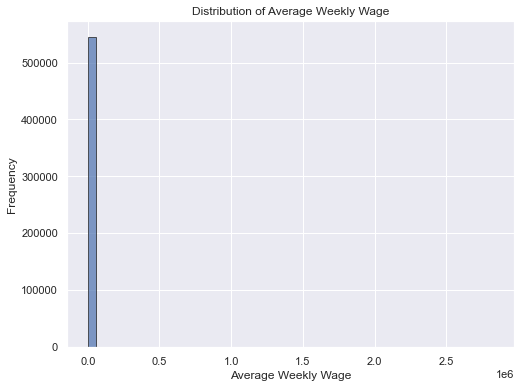

In [33]:
plt.figure(figsize=(8, 6))
plt.hist(train_df['Average Weekly Wage'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Average Weekly Wage')
plt.xlabel('Average Weekly Wage')
plt.ylabel('Frequency')
plt.show()

__Birth Year__

In [45]:
# Convert 'Accident Date' to datetime format if it's not already
train_df_temp2['Accident Date'] = pd.to_datetime(train_df_temp2['Accident Date'], errors='coerce')

# Calculate missing 'Birth Year' values
train_df_temp2['Birth Year'] = train_df_temp2['Birth Year'].fillna(train_df_temp2['Accident Date'].dt.year - train_df_temp2['Age at Injury'])

__Industry Code / Industry Code Description__

Before dealing with the missing values we want to check if the both variables have a 1:1 relationship, so when we are dealing with the missing values of one variables, the others need to be computed with regards to it.

In [50]:
# Check if each 'Industry Code' has only one unique 'Industry Code Description'
industry_code_to_description = train_df_temp2.groupby('Industry Code')['Industry Code Description'].nunique()

# Check if each 'Industry Code Description' has only one unique 'Industry Code'
description_to_industry_code = train_df_temp2.groupby('Industry Code Description')['Industry Code'].nunique()

print("Unique descriptions per 'Industry Code':")
print(industry_code_to_description)

print("\nUnique codes per 'Industry Code Description':")
print(description_to_industry_code)

# Validate if there is a 1:1 relationship
is_one_to_one = (industry_code_to_description.max() == 1) and (description_to_industry_code.max() == 1)

if is_one_to_one:
    print("\nIndustry Code and Industry Code Description have a 1:1 relationship.")
else:
    print("\nThere is no 1:1 relationship between Industry Code and Industry Code Description.")

Unique descriptions per 'Industry Code':
Industry Code
11.0    1
21.0    1
22.0    1
23.0    1
31.0    1
32.0    1
33.0    1
42.0    1
44.0    1
45.0    1
48.0    1
49.0    1
51.0    1
52.0    1
53.0    1
54.0    1
55.0    1
56.0    1
61.0    1
62.0    1
71.0    1
72.0    1
81.0    1
92.0    1
Name: Industry Code Description, dtype: int64

Unique codes per 'Industry Code Description':
Industry Code Description
ACCOMMODATION AND FOOD SERVICES                                 1
ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT    1
AGRICULTURE, FORESTRY, FISHING AND HUNTING                      1
ARTS, ENTERTAINMENT, AND RECREATION                             1
CONSTRUCTION                                                    1
EDUCATIONAL SERVICES                                            1
FINANCE AND INSURANCE                                           1
HEALTH CARE AND SOCIAL ASSISTANCE                               1
INFORMATION                                               

For each __Industry Code__, the first check shows that each code corresponds to only one unique description. This indicates that every industry code maps to a single description.

However, the second check reveals that some __Industry Code Descriptions__ map to more than one Industry Code. Specifically, the description "MANUFACTURING" maps to 3 different codes, and "RETAIL TRADE" and "TRANSPORTATION AND WAREHOUSING" each map to 2 different codes.

Since each Industry Code uniquely maps to one Industry Code Description, we can create a mapping from the Industry Code to its corresponding description and use that to fill in the missing values.

In [46]:
# Calculate the frequency distribution (weights) for the 'Industry Code' column
industry_code_counts = train_df_temp2['Industry Code'].value_counts(normalize=True)

# Create a list of possible values and their corresponding weights
categories = industry_code_counts.index.tolist()
weights = industry_code_counts.values.tolist()

# Impute missing values based on the weighted distribution
# np.random.choice randomly selects from the categories based on their weights
train_df_temp2['Industry Code'] = train_df_temp2['Industry Code'].apply(lambda x: np.random.choice(categories, p=weights) if pd.isna(x) else x)


In [51]:
# Mapping of 'Industry Code' to 'Industry Code Description' (ignoring missing values)
code_description_mapping = train_df_temp2.dropna(subset=['Industry Code Description']).set_index('Industry Code')['Industry Code Description'].to_dict()

# Fill missing 'Industry Code Description' values based on the 'Industry Code'
train_df_temp2['Industry Code Description'] = train_df_temp2['Industry Code'].map(code_description_mapping).combine_first(train_df_temp2['Industry Code Description'])


__WCIO Cause of Injury Code / Description__

In [ ]:
indusrty_code_max = train_df_temp2['Industry Code'].value_counts().max()
wcio_cause_max = train_df_temp2['WCIO Cause of Injury Code'].value_counts().max()
wcio_nature_max = train_df_temp2['WCIO Nature of Injury Code'].value_counts().max()
wcio_part_max = train_df_temp2['WCIO Part Of Body Code'].value_counts().max()

print(f"Percentage of the highest frequency of Industry Code: {round(indusrty_code_max / len(train_df_temp2),2)*100}%")
print(f"Percentage of the highest frequency of WCIO Cause of Injury Code: {round(wcio_cause_max / len(train_df_temp2),2)*100}%")
print(f"Percentage of the highest frequency of WCIO Nature of Injury Code: {round(wcio_nature_max / len(train_df_temp2),2)*100}%")
print(f"Percentage of the highest frequency of WCIO Part Of Body Code: {round(wcio_part_max / len(train_df_temp2),2)*100}%")

### 3.2 Outliers

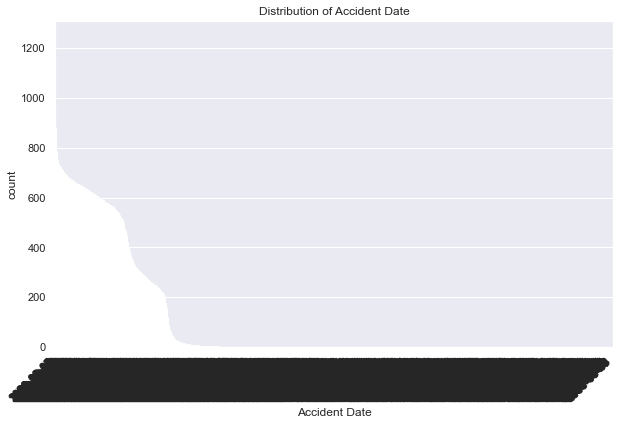

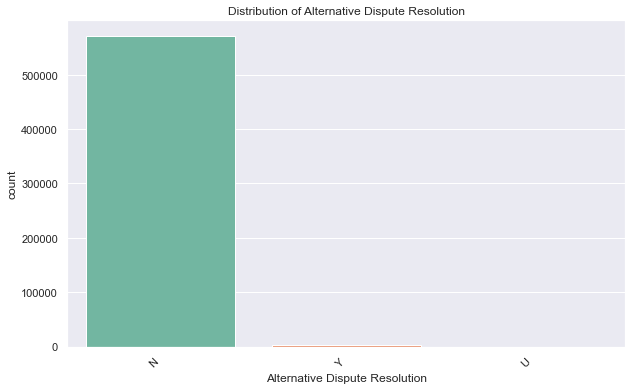

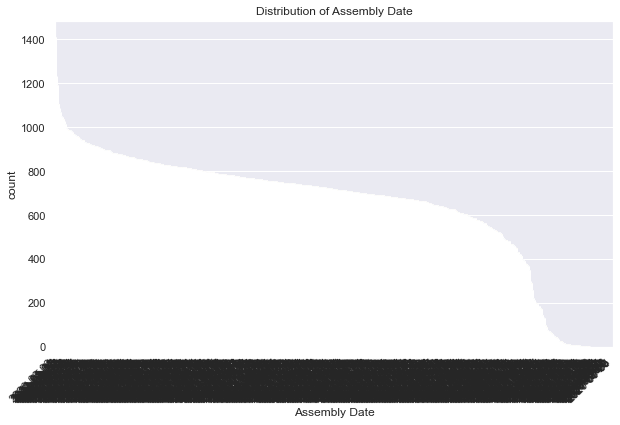

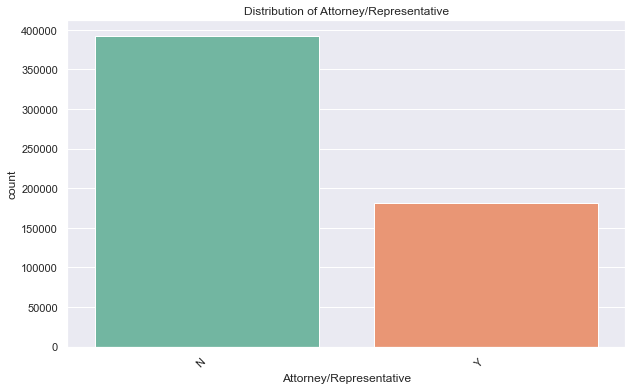

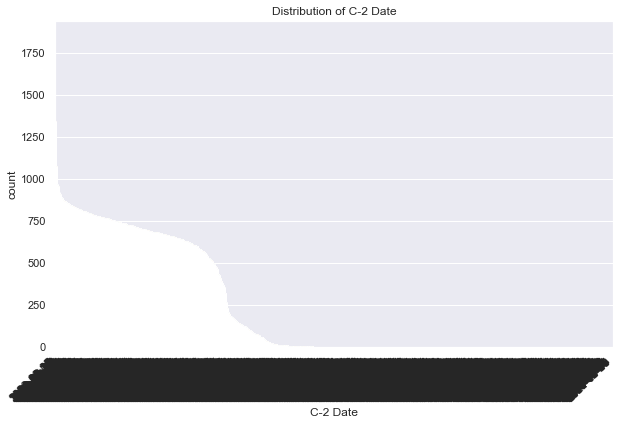

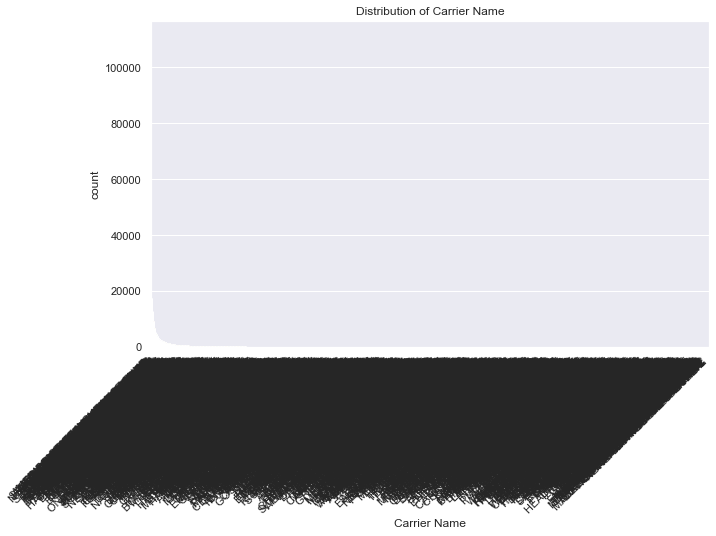

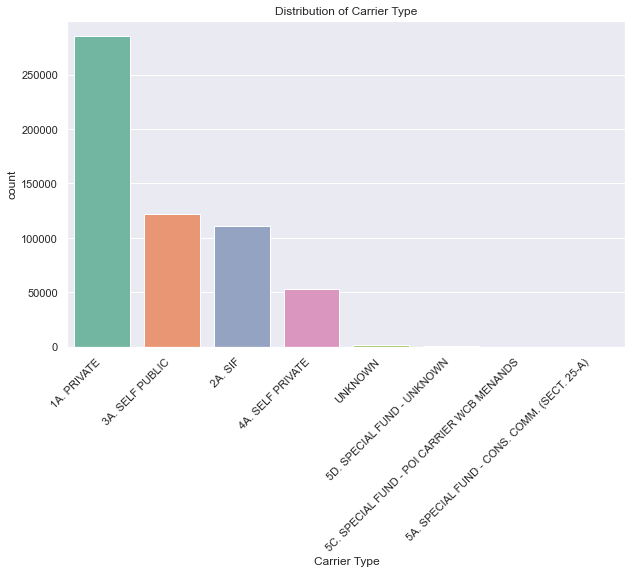

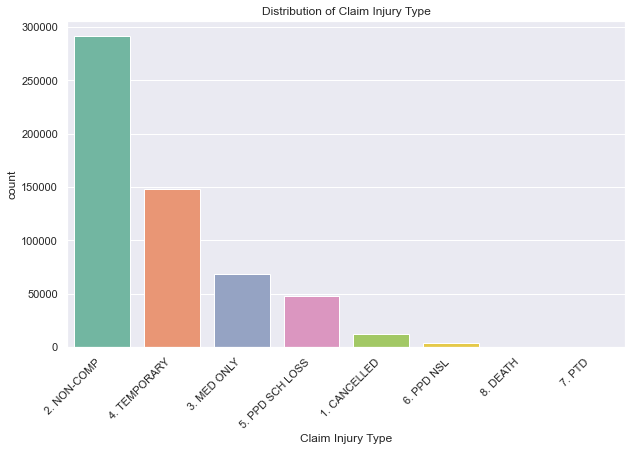

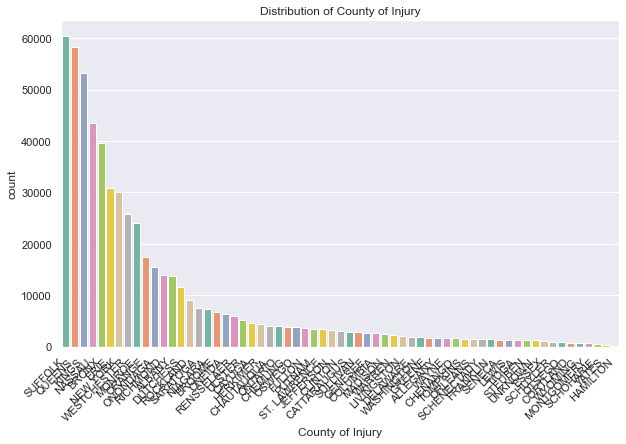

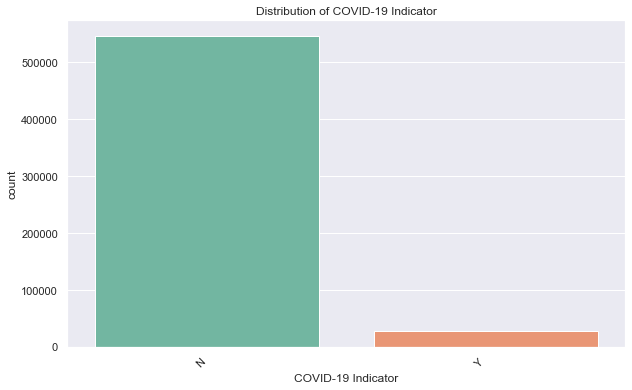

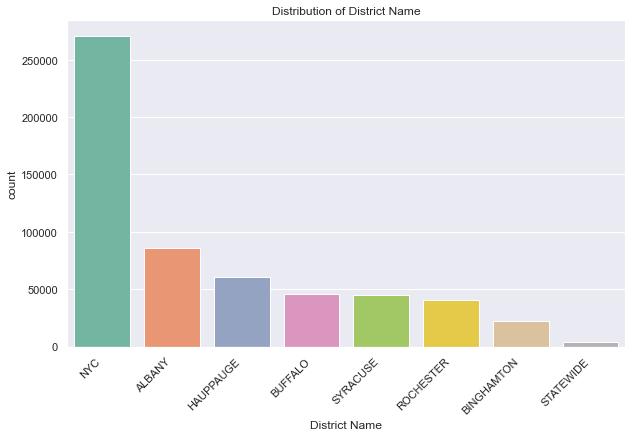

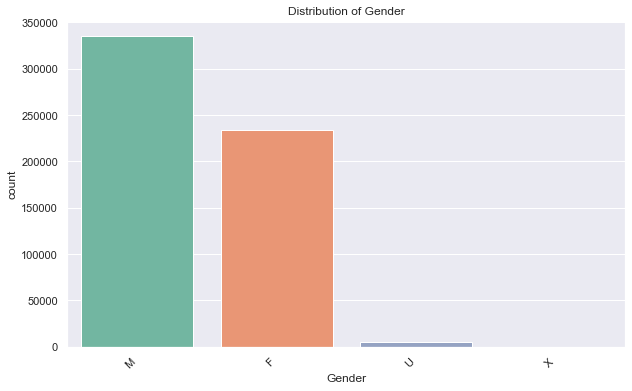

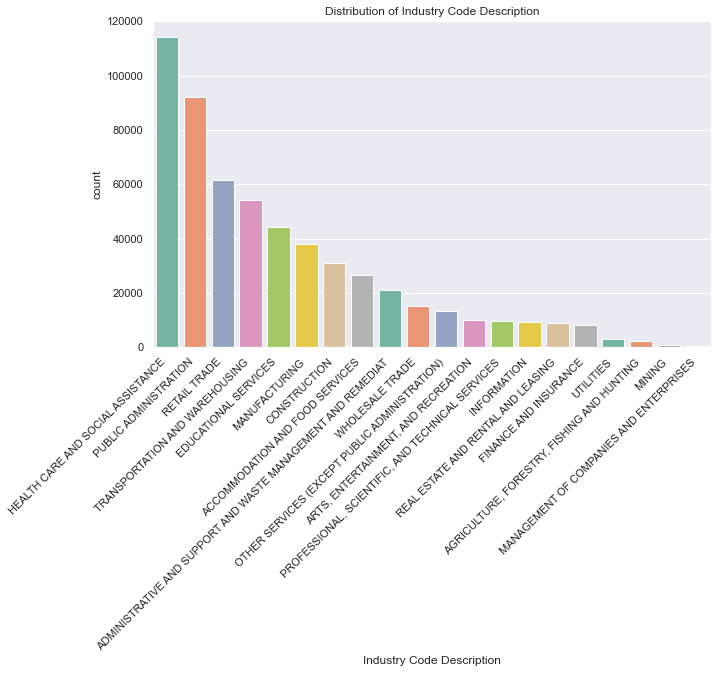

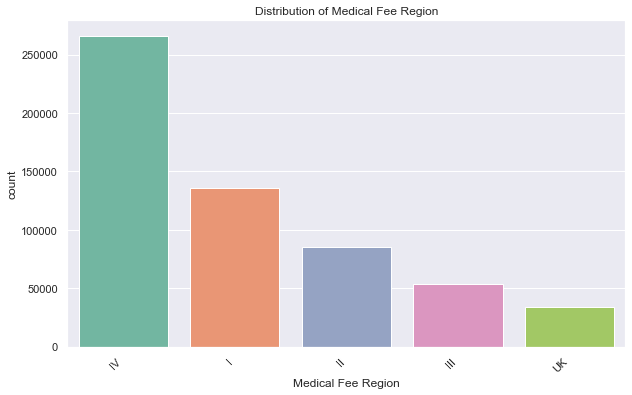

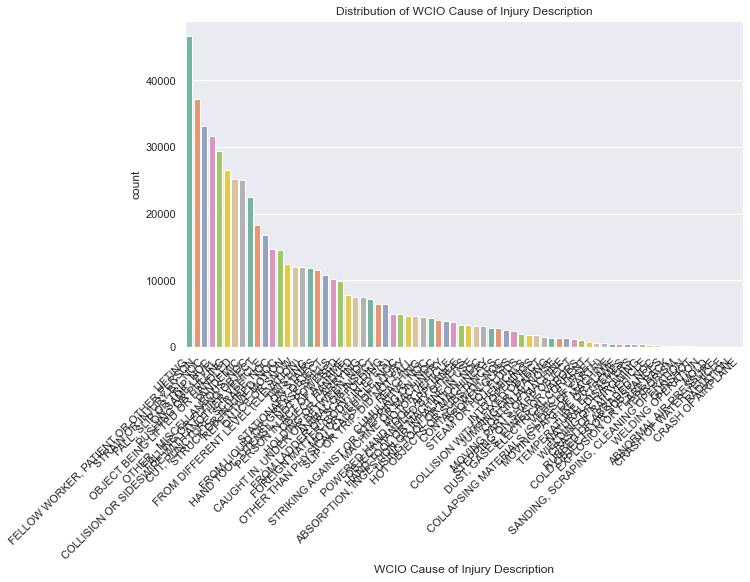

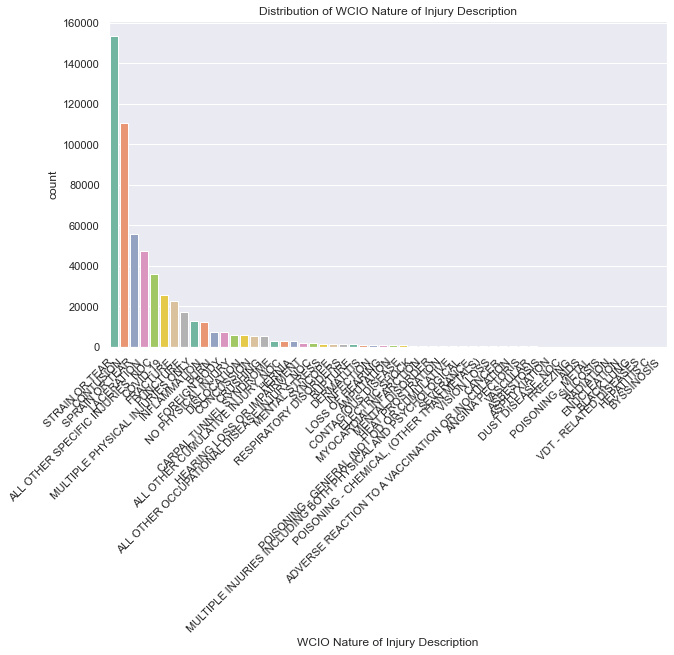

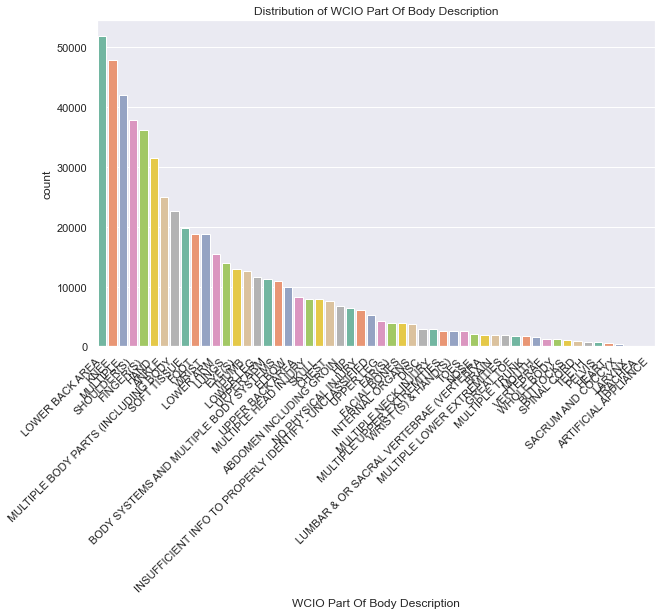

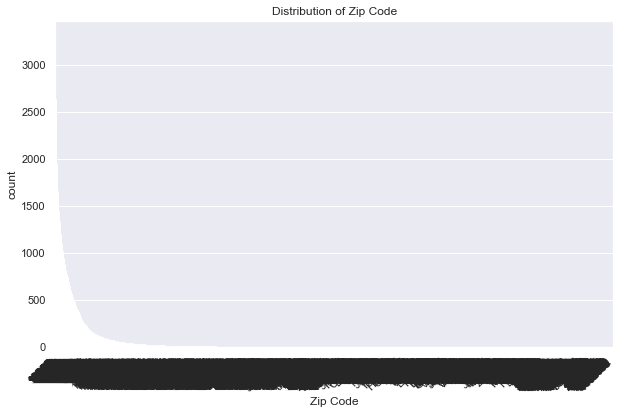

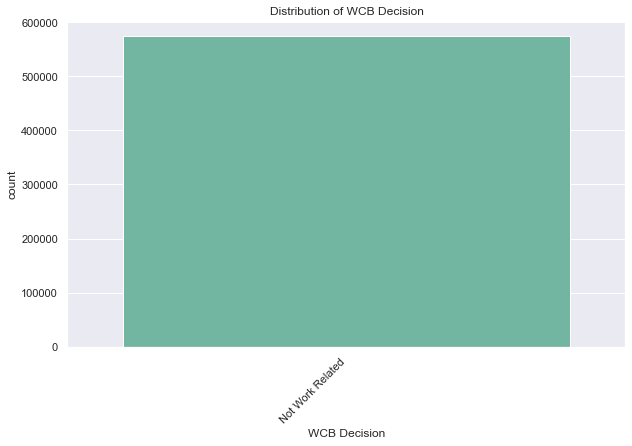

In [78]:
# Categorical columns
categorical_columns = train_df_temp2.select_dtypes(include=['object', 'category']).columns

# Plot categorical features
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=train_df_temp2, x=column, palette='Set2', order=train_df_temp2[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45, ha='right')
    plt.show()

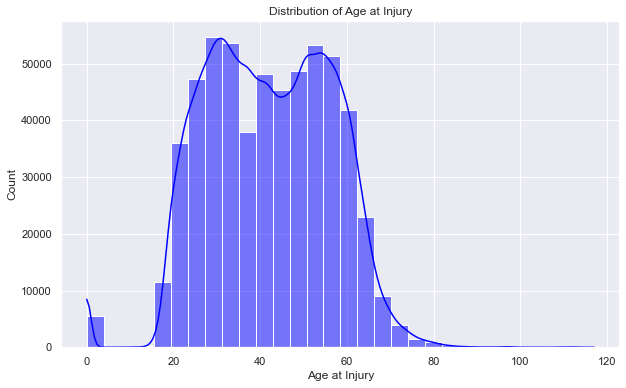

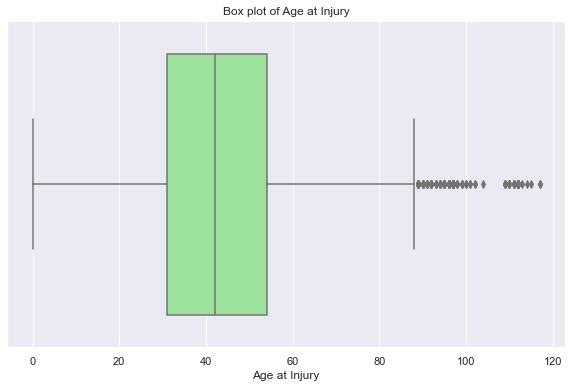

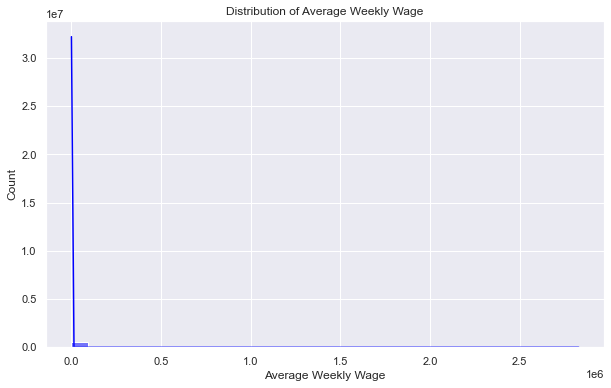

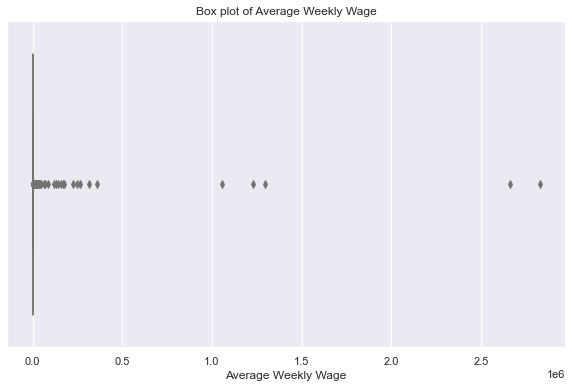

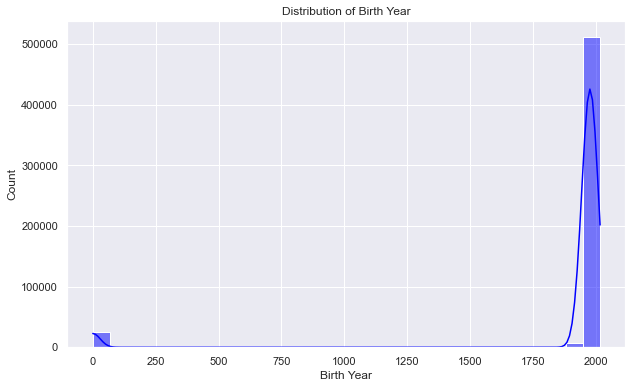

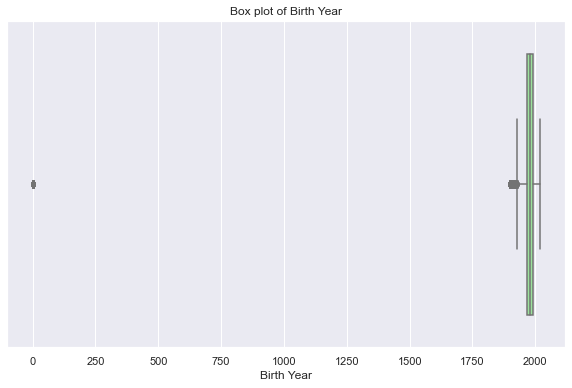

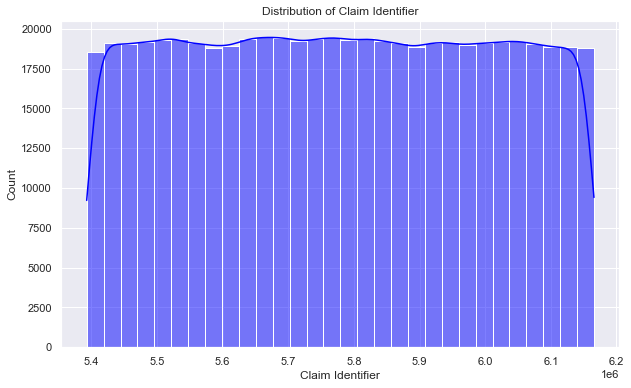

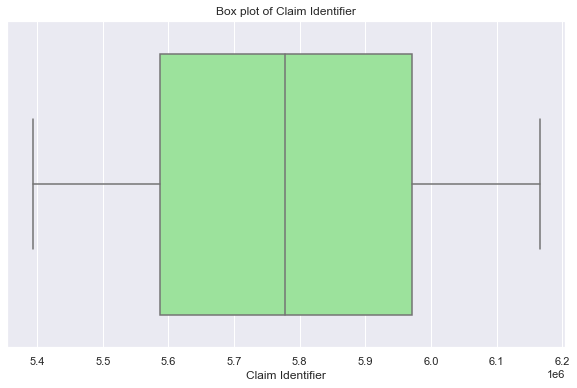

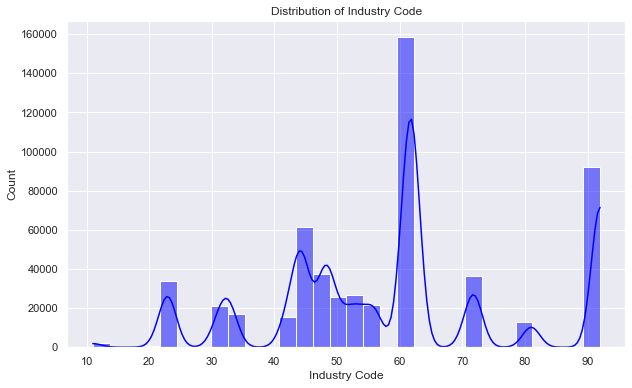

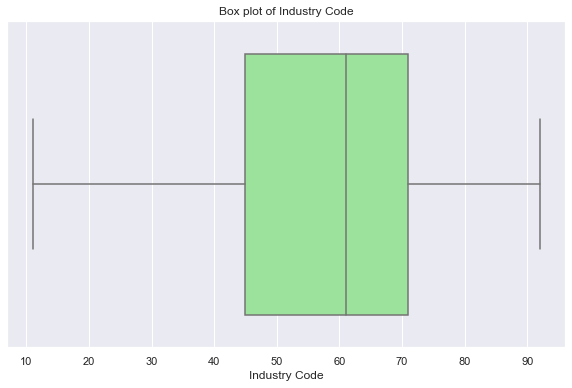

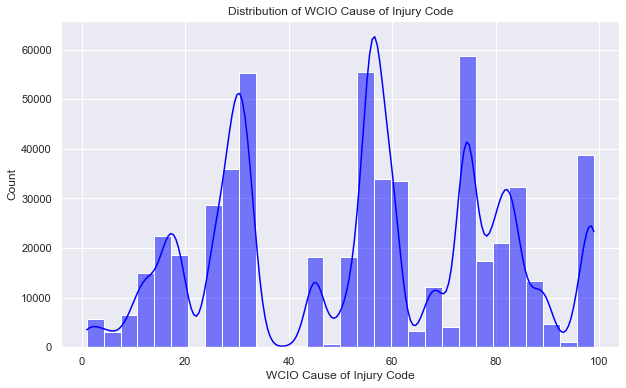

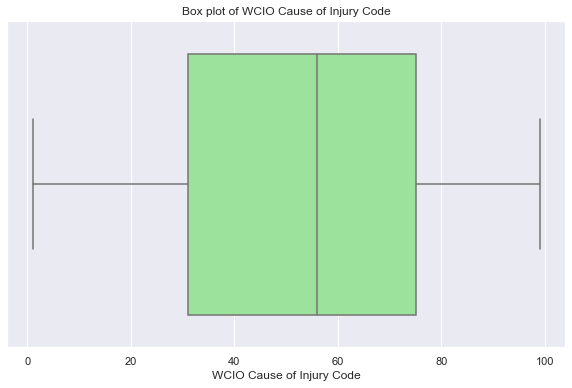

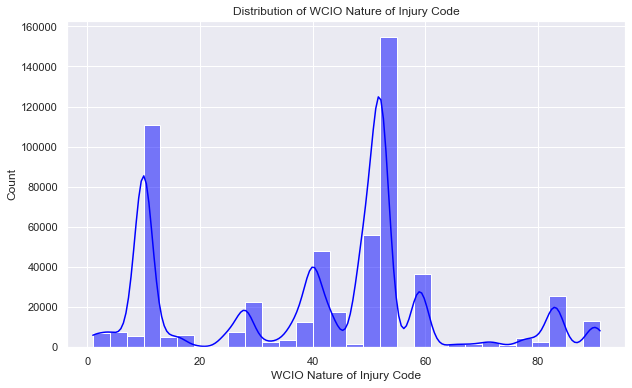

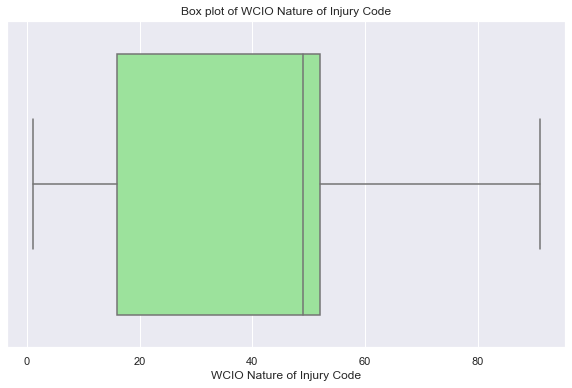

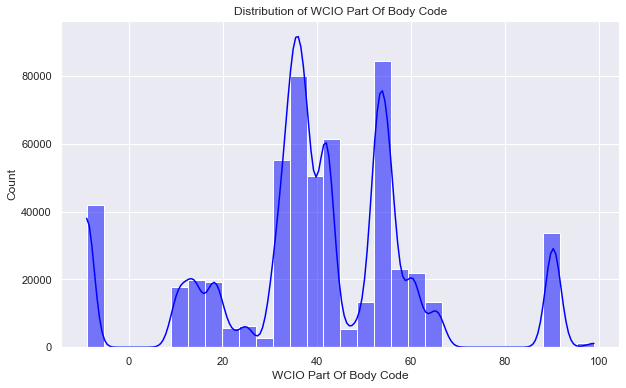

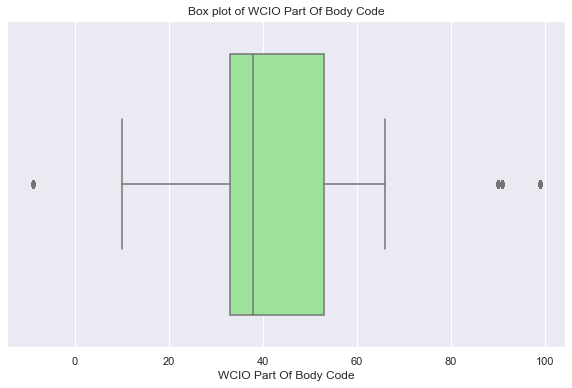

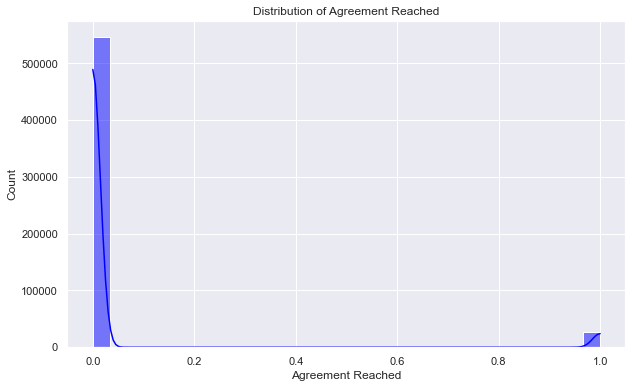

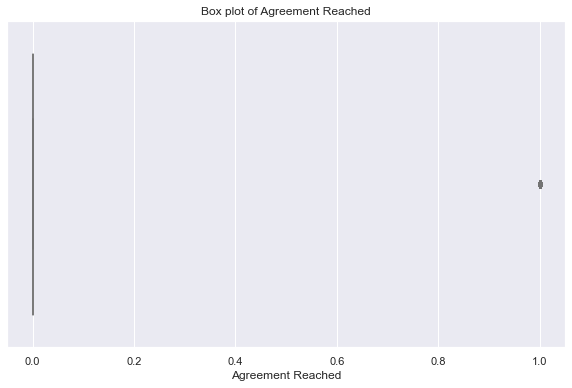

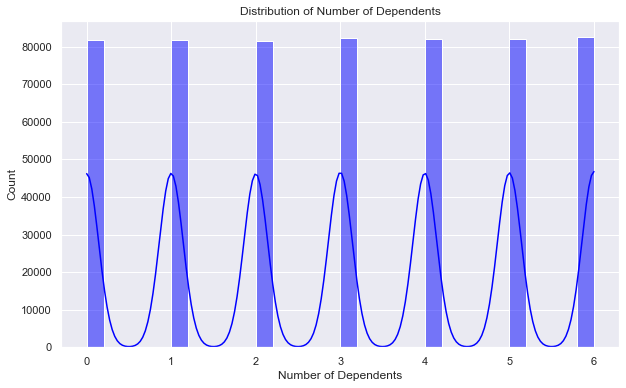

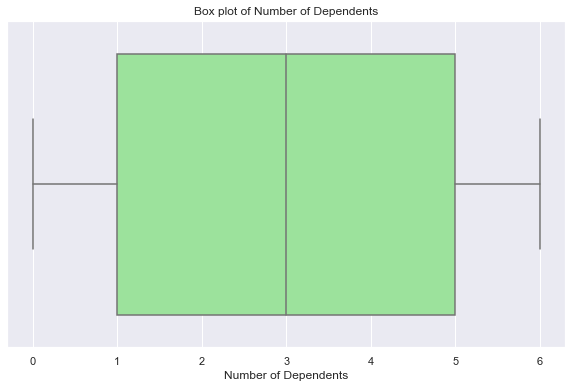

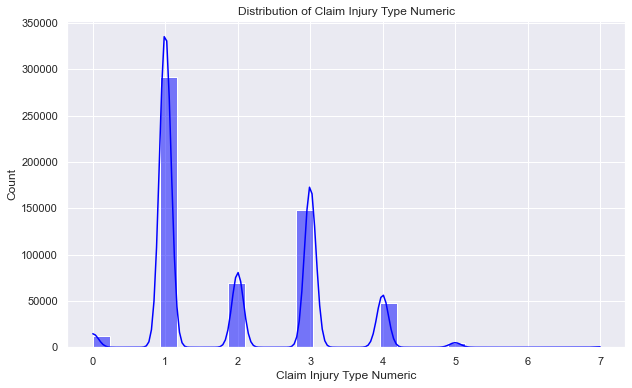

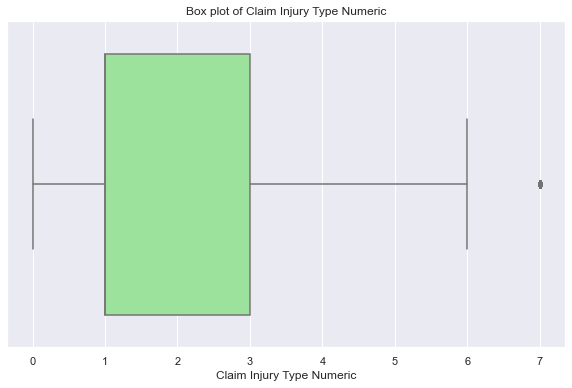

In [80]:
# Numerical columns
numerical_columns = train_df_temp2.select_dtypes(include=['number']).columns

# Plot numerical features
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(train_df_temp2[column].dropna(), kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {column}')
    plt.show()

    # Add box plot for outliers
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=train_df_temp2, x=column, color='lightgreen')
    plt.title(f'Box plot of {column}')
    plt.show()

In [17]:
train_df.corr()

,Age at Injury,Average Weekly Wage,Birth Year,Claim Identifier,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents,Claim Injury Type Numeric,Accident Days,Assembly Days,C-2 Days,C-3 Days,First Hearing Days
Age at Injury,1.000000,0.016196,0.012615,-0.010944,0.001631,-0.026822,0.023150,0.007608,0.019079,0.000461,0.126114,0.019172,-0.011038,-0.009556,0.021495,0.008625
Average Weekly Wage,0.016196,1.000000,0.001928,-0.003451,0.010695,0.002714,0.006149,-0.002199,0.005610,-0.001098,0.091868,0.004296,-0.003246,0.000870,0.002645,0.010234
Birth Year,0.012615,0.001928,1.000000,0.033717,0.024955,-0.004889,-0.007972,-0.013983,-0.032254,-0.001303,0.022443,0.067628,0.033555,0.029905,0.029424,0.028431
Claim Identifier,-0.010944,-0.003451,0.033717,1.000000,-0.008274,-0.026803,-0.039658,-0.227728,-0.077430,0.001610,-0.380843,0.469055,-0.007923,0.769747,0.942605,0.795135
Industry Code,0.001631,0.010695,0.024955,-0.008274,1.000000,0.045934,-0.004306,-0.035574,-0.076212,-0.000822,0.045021,0.010481,-0.008176,0.017716,-0.023497,0.042499
WCIO Cause of Injury Code,-0.026822,0.002714,-0.004889,-0.026803,0.045934,1.000000,0.171642,0.033642,-0.000178,0.000889,-0.023351,-0.033144,-0.026584,-0.017443,-0.048536,-0.078210
WCIO Nature of Injury Code,0.023150,0.006149,-0.007972,-0.039658,-0.004306,0.171642,1.000000,0.233692,0.029110,-0.002051,0.007839,-0.034718,-0.038642,-0.034210,-0.038958,-0.088658
WCIO Part Of Body Code,0.007608,-0.002199,-0.013983,-0.227728,-0.035574,0.033642,0.233692,1.000000,0.024204,0.000670,-0.019712,-0.119446,-0.223925,-0.183506,-0.289754,-0.271212
Agreement Reached,0.019079,0.005610,-0.032254,-0.077430,-0.076212,-0.000178,0.029110,0.024204,1.000000,-0.000189,0.225043,-0.181635,-0.076963,-0.135451,-0.095033,-0.146321
Number of Dependents,0.000461,-0.001098,-0.001303,0.001610,-0.000822,0.000889,-0.002051,0.000670,-0.000189,1.000000,-0.000464,-0.000105,0.001642,0.000998,0.000067,0.001913


### 3.3 Categorical Values

### 3.4 Feature Extraction

### 3.5 Data Scaling

## 4. Feature Selection <a id='features'></a>
[to the top](#top)

_"Define and implement an unambiguous strategy for feature selection. Use methods discussed in the course. Present and justify your final selection."_

## 5. Modeling and Evaluation <a id='modeling'></a>
[to the top](#top)

- _"Identify the type of the problem and select the relevant algorithms._
- _Use cross-validation to assess performance. Which metrics did you use and why?_
- _Train at least 1 model using the train dataset and obtain predictions for the test dataset."_

In [ ]:
# test

test test